### **Fighter Style Analysis**

In [ ]:
import pandas as pd
import numpy as np

attrs = pd.read_csv("data/fighter_attributes.csv")
hist = pd.read_csv("data/fighter_history.csv")


attrs_small = attrs[['fighter_id', 'name', 'style', 'stance', 'weight_class', 'country']]

# For this question, we’ll look at FIGHTS THAT THE FIGHTER WON
wins = hist[hist['fight_result'] == 'W'].copy()

# Create a simplified finish category:
#   - KO/TKO
#   - Submission
#   - Other (all kinds of decisions, DQ, draws, etc.)
wins['finish_category'] = np.where(
    wins['fight_result_type'] == 'KO-TKO', 'KO/TKO',
    np.where(wins['fight_result_type'] == 'SUBMISSION', 'Submission', 'Other')
)

# Merge in style info
wins_merged = wins.merge(
    attrs_small,
    on='fighter_id',
    how='left',
    validate='many_to_one'   # each fighter_id should map to one row in attrs
)

In [5]:
# Group by style and finish type
style_finish_counts = (
    wins_merged
    .groupby(['style', 'finish_category'])
    .size()
    .reset_index(name='n_fights')
)

# Pivot to have KO/TKO, Submission, Other as columns
style_finish_pivot = (
    style_finish_counts
    .pivot(index='style', columns='finish_category', values='n_fights')
    .fillna(0)
)

# Make sure the expected columns exist even if some category is missing for a style
for col in ['KO/TKO', 'Submission', 'Other']:
    if col not in style_finish_pivot.columns:
        style_finish_pivot[col] = 0

# Add total wins and rates
style_finish_pivot['total_wins']   = style_finish_pivot[['KO/TKO', 'Submission', 'Other']].sum(axis=1)
style_finish_pivot['ko_rate']      = style_finish_pivot['KO/TKO']     / style_finish_pivot['total_wins']
style_finish_pivot['submission_rate'] = style_finish_pivot['Submission'] / style_finish_pivot['total_wins']

# Optional: filter out styles with very few wins (to avoid noisy percentages)
min_wins = 20
style_summary = style_finish_pivot[style_finish_pivot['total_wins'] >= min_wins].sort_values('ko_rate', ascending=False)

print(style_summary[['KO/TKO', 'Submission', 'Other', 'total_wins', 'ko_rate', 'submission_rate']])

finish_category       KO/TKO  Submission   Other  total_wins   ko_rate  \
style                                                                    
kickboxing              59.0         9.0    59.0       127.0  0.464567   
striker               1101.0       275.0  1287.0      2663.0  0.413443   
karate                  15.0         2.0    23.0        40.0  0.375000   
sambo                    7.0        10.0     4.0        21.0  0.333333   
mixed martial artist   234.0       146.0   356.0       736.0  0.317935   
wrestling              259.0       167.0   464.0       890.0  0.291011   
grappling               15.0        14.0    24.0        53.0  0.283019   
boxing                  29.0        19.0    60.0       108.0  0.268519   
muay thai               47.0        23.0   107.0       177.0  0.265537   
judo                    14.0        13.0    28.0        55.0  0.254545   
kung fu                  5.0         7.0    10.0        22.0  0.227273   
freestyle               56.0        51

#### **Striker Analysis**
This code seeks to determine if strikers do in fact have more ko/tko finishes in comparison to all other fighting styles. This was done by grouping all striking fighter styles into the striker category and comparing the finishing stats of the striking styles to every other style in the dataset.

In [12]:
def is_striker(style):
    if pd.isna(style):
        return False
    s = style.lower()
    striking_keywords = [
        "boxing", "kickboxing", "muay thai", "striker",
        "taekwondo", "karate", "savate"
    ]
    return any(k in s for k in striking_keywords)

attrs['is_striker'] = attrs['style'].apply(is_striker)

wins_merged = wins.merge(
    attrs[['fighter_id', 'is_striker']],
    on='fighter_id',
    how='left'
)

# KO counts
ko_strikers = wins_merged[(wins_merged['is_striker'] == True) & (wins_merged['finish_category'] == "KO/TKO")].shape[0]
ko_non = wins_merged[(wins_merged['is_striker'] == False) & (wins_merged['finish_category'] == "KO/TKO")].shape[0]

# Total wins
total_strikers = wins_merged[wins_merged['is_striker'] == True].shape[0]
total_non = wins_merged[wins_merged['is_striker'] == False].shape[0]

print("Striker KO rate:", ko_strikers / total_strikers)
print("Non-striker KO rate:", ko_non / total_non)

Striker KO rate: 0.40236119974473517
Non-striker KO rate: 0.27949215305942515


In [13]:
import numpy as np
from math import sqrt
from scipy.stats import norm

# counts
count1 = ko_strikers
count2 = ko_non

n1 = total_strikers
n2 = total_non

# pooled proportion
p_pool = (count1 + count2) / (n1 + n2)

# standard error
se = sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

# z statistic
z = (count1/n1 - count2/n2) / se

# two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z)))

print("z =", z)
print("p-value =", p_value)

z = 11.80272662120494
p-value = 0.0


This result shows that strikers finish fight by KO at a much higher rate than non-strikers, and the difference is overwhelmingly significant.

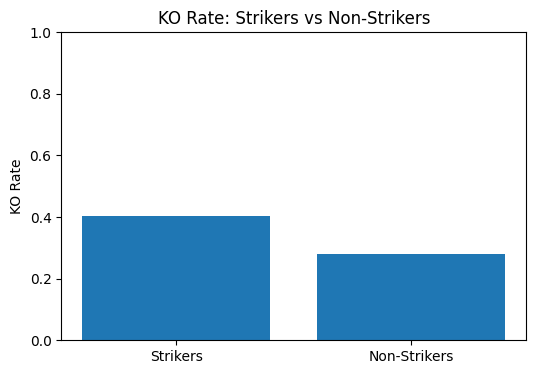

In [14]:
import matplotlib.pyplot as plt

ko_rate_strikers = ko_strikers / total_strikers
ko_rate_non = ko_non / total_non

plt.figure(figsize=(6,4))
plt.bar(['Strikers', 'Non-Strikers'], [ko_rate_strikers, ko_rate_non])
plt.ylabel("KO Rate")
plt.title("KO Rate: Strikers vs Non-Strikers")
plt.ylim(0, 1)
plt.show()

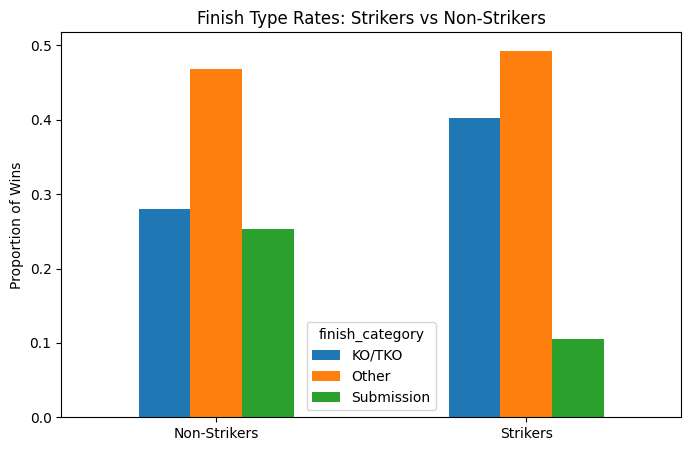

In [16]:
finish_rates = finish_counts.div(finish_counts.sum(axis=1), axis=0)

finish_rates.plot(kind='bar', figsize=(8,5))
plt.title("Finish Type Rates: Strikers vs Non-Strikers")
plt.ylabel("Proportion of Wins")
plt.xticks(rotation=0)
plt.show()

#### **Do Grapplers have Higher Submission Rates?**


In [22]:
def is_grappler(style):
    if pd.isna(style):
        return False
    s = style.lower()
    grappling_keywords = [
        "bjj", "brazilian jiu jitsu", "jiu-jitsu", "grappler",
        "wrestling", "wrestler", "sambo", "judo"
    ]
    return any(k in s for k in grappling_keywords)
attrs['is_grappler'] = attrs['style'].apply(is_grappler)

wins_merged = wins_merged.merge(
    attrs[['fighter_id', 'is_grappler']],
    on='fighter_id',
    how='left'
)

wins_merged['SUB_binary'] = wins_merged['finish_category'].apply(
    lambda x: 1 if x == "Submission" else 0
)

sub_grapplers = wins_merged[(wins_merged['is_grappler'] == True) & 
                            (wins_merged['SUB_binary'] == 1)].shape[0]

sub_non = wins_merged[(wins_merged['is_grappler'] == False) & 
                      (wins_merged['SUB_binary'] == 1)].shape[0]

total_grapplers = wins_merged[wins_merged['is_grappler'] == True].shape[0]
total_non = wins_merged[wins_merged['is_grappler'] == False].shape[0]

print("Grappler submission rate:", sub_grapplers / total_grapplers)
print("Non-grappler submission rate:", sub_non / total_non)

Grappler submission rate: 0.28917431192660553
Non-grappler submission rate: 0.16019736842105264


In [23]:
from math import sqrt
from scipy.stats import norm

# counts
count1 = sub_grapplers
count2 = sub_non

n1 = total_grapplers
n2 = total_non

# pooled proportion
p_pool = (count1 + count2) / (n1 + n2)

# standard error
se = sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

# z statistic
z = (count1/n1 - count2/n2) / se

# p-value
p_value = 2 * (1 - norm.cdf(abs(z)))

print("Submission z:", z)
print("p-value:", p_value)

Submission z: 13.983954675829983
p-value: 0.0


This p-value illustrates that grapplers do indeed submit more than every other fighting style.

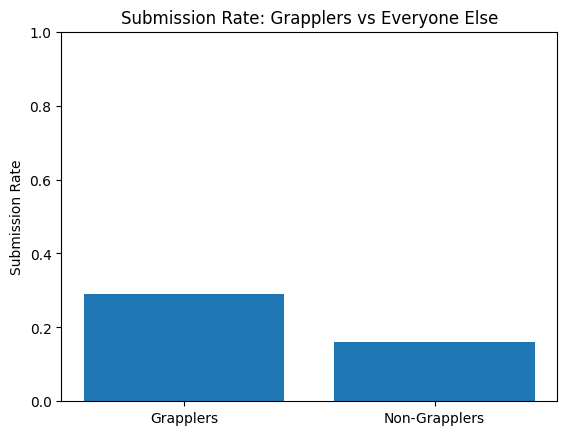

In [24]:
sub_rate_grappler = sub_grapplers / total_grapplers
sub_rate_non = sub_non / total_non

plt.bar(['Grapplers', 'Non-Grapplers'], [sub_rate_grappler, sub_rate_non])
plt.ylabel('Submission Rate')
plt.title('Submission Rate: Grapplers vs Everyone Else')
plt.ylim(0,1)
plt.show()

This code breaks down the fighters from the perspective of striker, wrestler, BJJ specialist, and MMA generalist.

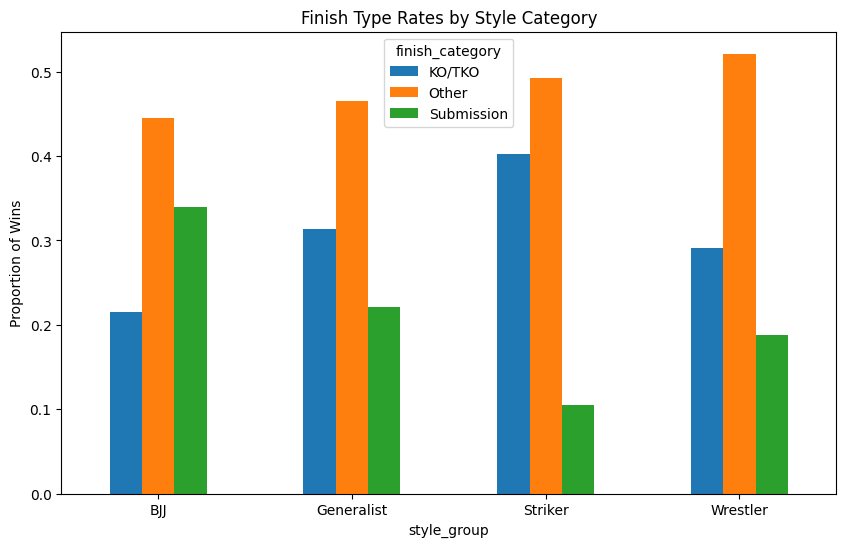

In [28]:
def classify_style(style):
    if pd.isna(style):
        return "Generalist"
        
    s = style.lower()

    # ---- BJJ Specialist ----
    bjj_keywords = ["bjj", "brazilian jiu jitsu", "jiu-jitsu", "jiu jitsu"]
    if any(k in s for k in bjj_keywords):
        return "BJJ"

    # ---- Wrestler ----
    wrestling_keywords = ["wrestling", "wrestler", "freestyle wrestling", "folkstyle"]
    if any(k in s for k in wrestling_keywords):
        return "Wrestler"

    # ---- Striker ----
    striking_keywords = [
        "boxing", "kickboxing", "muay thai", "striker",
        "taekwondo", "karate", "savate"
    ]
    if any(k in s for k in striking_keywords):
        return "Striker"

    # ---- Default ----
    # "MMA", "Mixed martial arts", empty, unknown styles
    return "Generalist"

attrs['style_group'] = attrs['style'].apply(classify_style)

wins_merged = wins.merge(
    attrs[['fighter_id', 'style_group']],
    on='fighter_id',
    how='left'
)

finish_table = pd.crosstab(
    wins_merged['style_group'],
    wins_merged['finish_category']
)

finish_table

finish_rates = finish_table.div(finish_table.sum(axis=1), axis=0)
finish_rates

finish_rates.plot(kind='bar', figsize=(10,6))
plt.title("Finish Type Rates by Style Category")
plt.ylabel("Proportion of Wins")
plt.xticks(rotation=0)
plt.show()

In [29]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(finish_table)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 460.45056207031206
p-value: 2.763628170625255e-96


In [30]:
import numpy as np

n = finish_table.sum().sum()
r, k = finish_table.shape

cramers_v = np.sqrt(chi2 / (n * (min(r-1, k-1))))
print("Cramer's V:", cramers_v)

Cramer's V: 0.1617006723639326
